In [1]:
from collections import defaultdict
import copy
import itertools as it
import json
import os
import pickle
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import collections as mc
import networkx as nximport
import numpy as np
from scipy import stats
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel
from rlpyt.utils.seed import make_seed, get_seed

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

Using TensorFlow backend.


In [504]:
TITLE_FONTSIZE = 36

In [505]:
def plot_topdown(env, fig, linewidth=2):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=linewidth)
                
def get_obs(env, pos):
    return env.get_obs_at(pos)[0][:3]

In [624]:
def plot_current_observation(ax, obs, title=None):
    ax.axis('off')
    ax.imshow(np.transpose(obs, [1, 2, 0]))
    if title is None:
        title = 'Current Observation'
    ax.set_title(title, fontsize=TITLE_FONTSIZE, pad=20)

## Exploration

In [551]:
eval_dir = '../data/fixed-spawn-small/run_6/'

In [562]:
landmarks = np.load('../data/fixed-spawn-small/run_6/landmarks_itr_9999.npz')

config = json.load(open('../data/fixed-spawn-small/run_6/params.json'))
config['env']['config'] = '../' + config['env']['config']

In [622]:
env = VizDoomEnv(**config['env'])
o = env.reset()

In [563]:
landmark_pos = landmarks['positions']

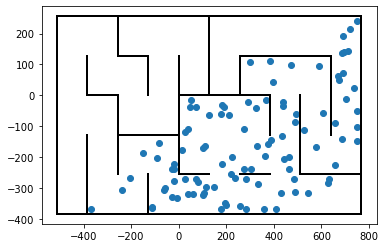

In [564]:
plot_topdown(env, plt)
plt.scatter(landmark_pos[:, 0], landmark_pos[:, 1])

In [548]:
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [549]:
itr = 50000 - 1

In [552]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [571]:
features = landmarks['features']
features = torch.Tensor(features).to(device)

In [572]:
s_features = dsr_model(features, mode='dsr')

In [573]:
s_features = torch.mean(s_features, dim=1)
s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
s_features = s_features.detach().cpu().numpy().squeeze()

In [580]:
def get_s_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

In [608]:
sfs_values = []
agent_pos = []
observations = []
obs = env.reset()
for i in range(500):
    observations.append(obs[9:12])
    agent_pos.append(env.agent_pos)
    cur_s_features = get_s_features(obs, feature_model, dsr_model)
    cur_sfs_values = np.dot(s_features, cur_s_features)
    sfs_values.append(cur_sfs_values)
    obs, r, d, env_info = env.step(env.action_space.sample())

In [616]:
agent_pos = np.vstack(agent_pos)
sfs_values = np.vstack(sfs_values)

In [617]:
smoothed_sfs_values = np.copy(sfs_values)
for i in range(8, len(sfs_values)):
    smoothed_sfs_values[i] = np.median(sfs_values[i:i+8], axis=0)

In [680]:
closest_sfs_values = smoothed_sfs_values.max(axis=1)

In [681]:
LANDMARK_SIZE = 144
PATH_SIZE = 400
LEGEND_FONTSIZE=32

def plot_exploration_landmark_graph(ax, env, landmark_pos, current_pos):
    ax.axis('off')
    plot_topdown(env, ax, WALL_WIDTH)
    plt.scatter(landmark_pos[:, 0], landmark_pos[:, 1], s=LANDMARK_SIZE, color='tab:blue', zorder=1,
                label='Existing Landmarks')
    ax.scatter(*current_pos, s=AGENT_SIZE, color='tab:red', marker='d', zorder=6, label='Current Position')
        
    ax.legend(fontsize=LEGEND_FONTSIZE, loc='lower right', bbox_to_anchor=(0.975, -0.35), labelspacing=0.6)
    ax.set_title('Landmark Graph', fontsize=TITLE_FONTSIZE)

In [688]:
np.where(closest_sfs_values < 0.8)

(array([ 31,  52,  53,  78,  79, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 196, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 323, 324, 325, 326, 327, 328,
        329, 330, 454, 455, 456, 457, 458, 459, 460, 461, 462]),)

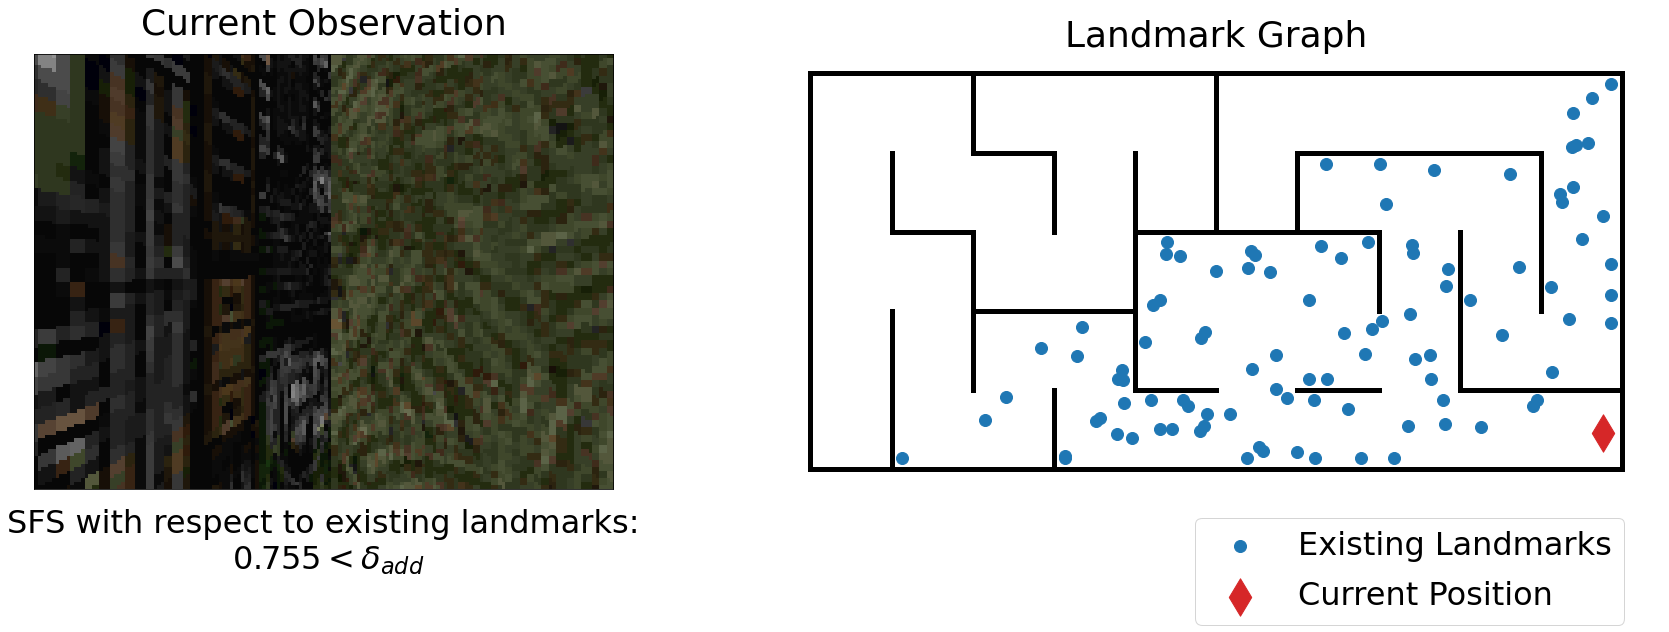

In [691]:
for idx in [454]:
# for idx in range(len(observations)):
    fig = plt.figure(figsize=(32,  8))
    gridspec = {'wspace': 0}
    gs = fig.add_gridspec(1, 2, **gridspec)
    
    ax1 = fig.add_subplot(gs[0, 0])
    observation = observations[idx]
    closest_sfs_value = closest_sfs_values[idx]
    
    plot_current_observation(ax1, observation)
    if closest_sfs_value < 0.9:
        comparison_text = r'$< \delta_{add}$'
    else:
        comparison_text = r'$\nless \delta_{add}$'
    ax1.axis('on')
    ax1.set_xlabel('SFS with respect to existing landmarks:\n {:.3f}'.format(closest_sfs_value) +
                   comparison_text,
                   fontsize=LEGEND_FONTSIZE, labelpad=20)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    
    ax2 = fig.add_subplot(gs[0, 1])
    current_pos = agent_pos[idx, :2]
    plot_exploration_landmark_graph(ax2, env, landmark_pos, current_pos)

#     plt.savefig(video_dir + '/full%03d.png' % idx, bbox_inches='tight', pad_inches=0.65)
#     plt.close()

## Planning

In [307]:
WALL_WIDTH = 5

In [284]:
DOT_SIZE = 700
START_COLOR = '#ff99ff'
GOAL_COLOR = 'yellow'

In [409]:
# video_data = np.load('../video-data/fixed-spawn_itr199999_hardest_traj13.npz', allow_pickle=True)
video_data = np.load('../video-data/fixed-spawn_itr199999_hardest_traj13.npz', allow_pickle=True)

In [389]:
landmarks = np.load('../data/fixed-spawn-small/run_6/landmarks_itr_199999.npz')

config = json.load(open('../data/fixed-spawn-small/run_6/params.json'))
config['env']['config'] = '../' + config['env']['config']

In [396]:
env = VizDoomEnv(**config['env'])
o = env.reset()

In [410]:
positions = video_data['position']
observations = video_data['observation']

closest_landmarks = video_data['closest_landmark'].squeeze()
path_to_goal = video_data['path_to_goal']
path_idx = video_data['path_idx'].squeeze()

start = video_data['start']
goal = video_data['goal']

landmark_pos = landmarks['positions']

In [276]:
video_dir = '../videos'

In [353]:
AGENT_SIZE = 700

In [507]:
def plot_closest_landmark(ax, landmark):
    ax.axis('off')
    ax.imshow(np.transpose(landmark, [1, 2, 0]))
    ax.set_title('Target Landmark', fontsize=TITLE_FONTSIZE, pad=20)

In [508]:
TRAJ_SIZE = 100

def plot_agent_trajectory(ax, env, start, goal, trajectory, current_pos):
    ax.axis('off')
    plot_topdown(env, plt, WALL_WIDTH)
    ax.scatter(*start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start', zorder=2)
    ax.scatter(*goal[:2], marker='s', s=DOT_SIZE, color=GOAL_COLOR, linewidths=3,
                edgecolor='black', label='Goal', zorder=2)
    plt.set_cmap('viridis')
    ax.scatter(trajectory[:, 0], trajectory[:, 1], s=TRAJ_SIZE, c=range(len(trajectory)), zorder=1)
    if len(trajectory):
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], s=TRAJ_SIZE, c=len(trajectory) - 1, zorder=1, label='Trajectory')
    ax.scatter(*current_pos, s=AGENT_SIZE, color='tab:red', marker='d', zorder=3, label='Current Position')
#     ax.legend(fontsize=LEGEND_FONTSIZE, loc='upper right', bbox_to_anchor=(0.97, 1.2), labelspacing=0.8)
    ax.set_title('Agent Trajectory', fontsize=TITLE_FONTSIZE)

In [531]:
LANDMARK_SIZE = 144
PATH_SIZE = 400
LEGEND_FONTSIZE=32

def plot_landmark_graph(ax, env, start, goal, landmark_pos, landmark_path, current_pos):
    path_landmarks = landmark_pos[path, :2]
    non_path_landmarks = np.delete(landmark_pos[:, :2], path, axis=0)

    ax.axis('off')
    plot_topdown(env, ax, WALL_WIDTH)
    ax.scatter(*start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start', zorder=5)
    ax.scatter(*goal[:2], marker='s', s=DOT_SIZE, color=GOAL_COLOR, linewidths=3,
                edgecolor='black', label='Goal', zorder=5)
#     plt.scatter(non_path_landmarks[:, 0], non_path_landmarks[:, 1], s=LANDMARK_SIZE, color='gray', zorder=1, alpha=0.5)
    ax.scatter(*current_pos, s=AGENT_SIZE, color='tab:red', marker='d', zorder=6, label='Current Position')
    if len(path_landmarks):
        ax.scatter(*path_landmarks[0], s=DOT_SIZE, color='tab:blue', edgecolor='tab:red', linewidth=5, zorder=3, label='Target Landmark')
    ax.scatter(path_landmarks[:, 0], path_landmarks[:, 1], s=DOT_SIZE, color='tab:blue', zorder=2, label='Landmark Path')
        
    full_path = [*path_landmarks, goal[:2]]

    full_path = list(map(tuple, full_path))
    path_lines = list(zip(full_path, full_path[1:]))

    for line in path_lines:
        x1, y1 = line[0]
        x2, y2 = line[1]
        ax.arrow(x1, y1, x2 - x1, y2 - y1, linewidth=4, head_width=10, length_includes_head=True, color='black', zorder=4)
    
    ax.legend(fontsize=LEGEND_FONTSIZE, loc='lower right', bbox_to_anchor=(1.5, 0.025), labelspacing=0.6)
    ax.set_title('Landmark Path to Goal', fontsize=TITLE_FONTSIZE)

In [535]:
# for idx in [len(observations) - 1]:
for idx in range(len(observations)):
    fig = plt.figure(figsize=(32, 32))
    gridspec = {'height_ratios': [3, 1], 'wspace': 0.1, 'hspace': -0.35}
    gs = fig.add_gridspec(2, 2, **gridspec)
    
    ax1 = fig.add_subplot(gs[0, 0])
    observation = observations[idx]
    plot_current_observation(ax1, observation)
#     plt.savefig(video_dir + '/obs%03d.png' % idx, bbox_inches='tight')
#     plt.close()

    if closest_landmarks[idx] == len(landmark_pos):
        closest_landmark = get_obs(env, goal)
    else:
        closest_landmark = get_obs(env, landmark_pos[closest_landmarks[idx]])
    ax2 = fig.add_subplot(gs[0, 1])
    plot_closest_landmark(ax2, closest_landmark)
#     plt.savefig(video_dir + '/landmark%03d.png' % idx, bbox_inches='tight')
#     plt.close()
    
    ax3 = fig.add_subplot(gs[1, 0])
    trajectory = positions[:idx]
    current_pos = positions[idx, :2]
    plot_agent_trajectory(ax3, env, start, goal, trajectory, current_pos)
#     plt.savefig(video_dir + '/trajectory%03d.png' % idx, bbox_inches='tight')
#     plt.close()

    ax4 = fig.add_subplot(gs[1, 1])
    path = path_to_goal[idx][path_idx[idx]:-1]
    plot_landmark_graph(ax4, env, start, goal, landmark_pos, path, current_pos)
#     plt.savefig(video_dir + '/graph%03d.png' % idx, bbox_inches='tight')
#     plt.close()

    plt.savefig(video_dir + '/full%03d.png' % idx, bbox_inches='tight', pad_inches=0.65)
    plt.close()